In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

In [2]:
# ---- Global constants ----
MAX_GAP = 3600  # seconds (1 hour)
MIN_GAP = 60    # seconds (1 minute)


In [3]:
# ---- Fallback dummy model ----
# Si 'global_model' n'est pas défini dans le notebook (par exemple si aucun modèle n'est encore chargé),
# on crée un modèle factice qui renvoie NaN ou qui fait simplement un forward-fill.
# Remplace-le par ton propre modèle d'interpolation/prédiction si nécessaire.
if 'global_model' not in globals():
    import numpy as np
    class DummyModel:
        def predict(self, X):
            # renvoie simplement NaN pour chaque ligne : à adapter
            return np.full(len(X), np.nan)
    global_model = DummyModel()
    print("✅ 'global_model' absent : utilisation d'un DummyModel qui renvoie NaN.")

✅ 'global_model' absent : utilisation d'un DummyModel qui renvoie NaN.


In [4]:
df = pd.read_csv("../vessel-total-clean-final.csv")

# Convertir la colonne date en datetime
df['base_date_time'] = pd.to_datetime(df['base_date_time'])

# Trier par mmsi + date (si plusieurs navires)
df = df.sort_values(['mmsi', 'base_date_time'])

In [5]:
df = df.sort_values(['mmsi', 'base_date_time'])
df['delta'] = df.groupby('mmsi')['base_date_time'].diff().dt.total_seconds()

# Choisis ici le MMSI à visualiser
mmsi_example = df['mmsi'].unique()[5]
df_boat = df[df['mmsi'] == mmsi_example].copy()

gaps = df_boat[df_boat['delta'] > 100]


In [6]:
# ── Diagnostic des gaps réels ──
print(f"=== Diagnostic pour le navire {mmsi_example} ===")
for i in range(1, len(df_boat)):
    t0 = df_boat.iloc[i-1]['base_date_time']
    t1 = df_boat.iloc[i  ]['base_date_time']
    gap = (t1 - t0).total_seconds()
    if gap > MAX_GAP:
        print(f"Gap de {gap:.0f}s entre lignes {i-1} et {i} : {t0} → {t1}")
print("=== Fin du diagnostic ===\n")

=== Diagnostic pour le navire 241452000 ===
Gap de 15870s entre lignes 8 et 9 : 2023-05-25 12:07:03 → 2023-05-25 16:31:33
Gap de 4920s entre lignes 9 et 10 : 2023-05-25 16:31:33 → 2023-05-25 17:53:33
Gap de 86639s entre lignes 71 et 72 : 2023-05-25 23:57:51 → 2023-05-27 00:01:50
Gap de 86490s entre lignes 639 et 640 : 2023-05-27 23:58:34 → 2023-05-29 00:00:04
Gap de 24023s entre lignes 1022 et 1023 : 2023-05-29 12:44:22 → 2023-05-29 19:24:45
Gap de 86688s entre lignes 1184 et 1185 : 2023-05-29 23:55:16 → 2023-05-31 00:00:04
=== Fin du diagnostic ===



In [7]:
def predict_gap(segment_df, model, step=60):
    
    row_prev = segment_df.iloc[0]
    row_next = segment_df.iloc[1]
    t0 = row_prev['base_date_time']
    total_s = int((row_next['base_date_time'] - t0).total_seconds())
    n_steps = total_s // step

    # interpolation linéaire de sog et cog
    sogs = np.linspace(row_prev['sog'], row_next['sog'], n_steps+1)
    cogs = np.linspace(row_prev['cog'], row_next['cog'], n_steps+1)

    # état initial
    state = {
        'lat':    row_prev['lat'],
        'lon':    row_prev['lon'],
        'length': row_prev['length'],
        'draft':  row_prev['draft']
    }

    filled = []
    for i in range(1, n_steps):
        state['sog']     = sogs[i]
        state['cog']     = cogs[i]
        state['heading'] = row_prev['heading']

        X = pd.DataFrame([{**state, 'delta_seconds': step}])
        # réordonner les colonnes comme à l'entraînement
        try:
            X = X[model.feature_names_in_]
        except AttributeError:
            feature_order = ['lat','lon','sog','cog','heading','length','draft','delta_seconds']
            X = X[feature_order]

        lat_p, lon_p = model.predict(X)[0]
        t_pred = t0 + pd.Timedelta(seconds=i*step)

        filled.append({
            'mmsi':           row_prev['mmsi'],
            'base_date_time': t_pred,
            'lat':            lat_p,
            'lon':            lon_p
        })
        # mise à jour de la position pour l’itération suivante
        state['lat'], state['lon'] = lat_p, lon_p

    return pd.DataFrame(filled)

In [8]:

def fill_gaps_for_boat(df_boat: pd.DataFrame,
                       model,
                       step: int = 60,
                       min_gap: int = MIN_GAP,
                       max_gap: int = MAX_GAP) -> pd.DataFrame:
    """Return df with gaps between min_gap and max_gap filled at given step."""
    df_boat = df_boat.sort_values('base_date_time').copy()
    df_boat['delta'] = df_boat['base_date_time'].diff().dt.total_seconds().fillna(0)

    rows = [df_boat.iloc[[0]]]
    for i in range(1, len(df_boat)):
        gap = df_boat.iloc[i]['delta']
        if (gap <= min_gap) or (gap > max_gap):
            rows.append(df_boat.iloc[[i]])
            continue
        seg = df_boat.iloc[[i-1, i]]
        preds = predict_gap(seg, model, step=step)
        rows.append(preds.iloc[1:])
        rows.append(df_boat.iloc[[i]])
    return pd.concat(rows, ignore_index=True)


In [9]:
import joblib
model = joblib.load("trajectoire.pkl")


step = 60  # 1 min
min_gap_fill = MIN_GAP
max_gap_fill = MAX_GAP  # 1 hour


all_filled = []
for i in range(1, len(df_boat)):
    gap = df_boat.iloc[i]['delta']
    if (gap <= min_gap_fill) or (gap > max_gap_fill):
        continue

    row_prev = df_boat.iloc[i-1]
    row_next = df_boat.iloc[i]
    segment  = pd.DataFrame([row_prev, row_next])

    df_seg = predict_gap(segment, model, step=step)
    all_filled.append(df_seg)

filled_df = pd.concat(all_filled, ignore_index=True)
print("✅ Points prédits pour comblement :", len(filled_df))

✅ Points prédits pour comblement : 1664


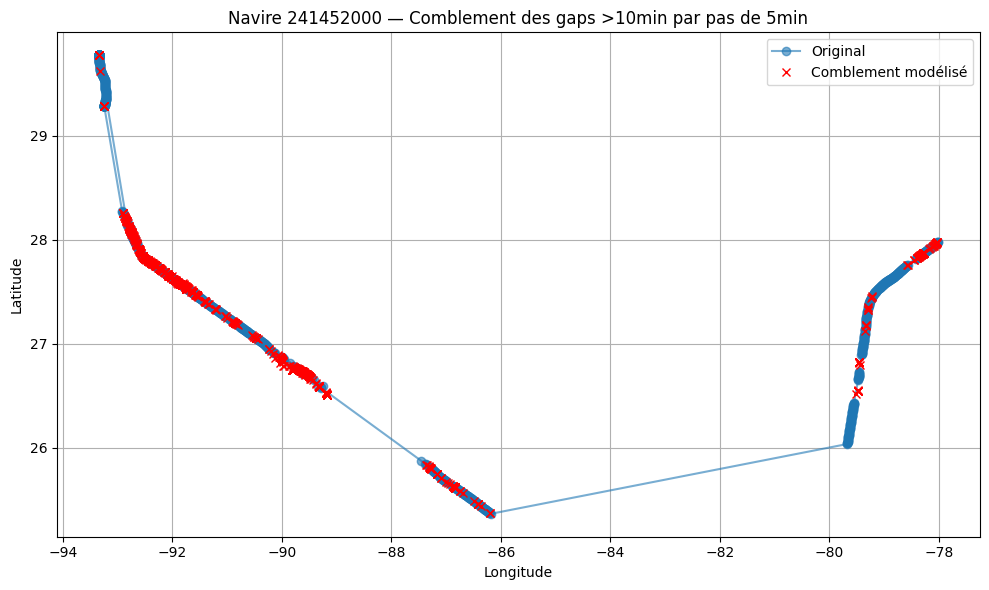

In [10]:
plt.figure(figsize=(10,6))
# trajectoire mesurée
plt.plot(df_boat['lon'], df_boat['lat'], 'o-', label='Original', alpha=0.6)
# prédictions comblées
plt.plot(filled_df['lon'], filled_df['lat'], 'x', label='Comblement modélisé', color='red')

plt.title(f"Navire {mmsi_example} — Comblement des gaps >10min par pas de 5min")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# %%  — Carte Folium
import folium

# centre grossier : milieu de la trajectoire
center = [
    0.5 * (df_boat.lat.min() + df_boat.lat.max()),
    0.5 * (df_boat.lon.min() + df_boat.lon.max())
]

m = folium.Map(location=center, zoom_start=7, tiles="cartodbpositron")

# ---------- points originaux (bleu) ----------
orig_layer = folium.FeatureGroup(name="Positions originales").add_to(m)
for lat, lon, t in zip(df_boat.lat, df_boat.lon, df_boat.base_date_time):
    folium.CircleMarker(
        location=[lat, lon],
        radius=3,
        color="#1f77b4",              # contour bleu
        fill=True, fill_color="#1f77b4", fill_opacity=0.8,
        tooltip=str(t)
    ).add_to(orig_layer)

# ---------- points comblés (rouge) ----------
if not filled_df.empty:
    fill_layer = folium.FeatureGroup(name="Positions comblées").add_to(m)
    for lat, lon, t in zip(filled_df.lat, filled_df.lon, filled_df.base_date_time):
        folium.CircleMarker(
            location=[lat, lon],
            radius=3,
            color="#d62728",
            fill=True, fill_color="#d62728", fill_opacity=0.9,
            tooltip=f"Comblé : {t}"
        ).add_to(fill_layer)

# bascule d’affichage
folium.LayerControl().add_to(m)

m    # affiche la carte interactive dans le notebook

In [12]:
# ---- Traitement de tous les navires + résumé ----
unique_mmsi = df['mmsi'].unique()
summary = []

for mmsi in unique_mmsi:
    try:
        df_boat = (df[df['mmsi'] == mmsi]
                   .sort_values('base_date_time')
                   .copy())

        # calcul de delta pour ce MMSI
        df_boat['delta'] = df_boat['base_date_time'].diff().dt.total_seconds()

        # modèle (déjà défini ou DummyModel)
        model = global_model

        # remplissage des gaps ≤ 1 h
        df_filled = fill_gaps_for_boat(df_boat, model)

        nb_gap_ok = df_boat['delta'].between(MIN_GAP, MAX_GAP).sum()

        summary.append({
            'mmsi': int(mmsi),
            'pts_originaux': len(df_boat),
            'pts_ajoutes': len(df_filled) - len(df_boat),
            'gaps_combles': int(nb_gap_ok)
        })

    except Exception as e:
        print(f"⚠️  {mmsi} ignoré ({e})")
        continue

# ---- Affichage du résumé ----
summary_df = pd.DataFrame(summary)

if summary_df.empty:
    print("❌ Aucun navire n'a été traité : vérifie le modèle ou les données.")
else:
    summary_df = (summary_df
                  .sort_values('gaps_combles', ascending=False)
                  .reset_index(drop=True))
    print(f"🚢 Navires traités : {len(summary_df)}")
    display(summary_df.head(20))

⚠️  205776000 ignoré (cannot unpack non-iterable numpy.float64 object)
⚠️  209513000 ignoré (cannot unpack non-iterable numpy.float64 object)
⚠️  212040000 ignoré (cannot unpack non-iterable numpy.float64 object)
⚠️  215583000 ignoré (cannot unpack non-iterable numpy.float64 object)
⚠️  228075700 ignoré (cannot unpack non-iterable numpy.float64 object)
⚠️  241452000 ignoré (cannot unpack non-iterable numpy.float64 object)
⚠️  241770000 ignoré (cannot unpack non-iterable numpy.float64 object)
⚠️  244561000 ignoré (cannot unpack non-iterable numpy.float64 object)
⚠️  244810614 ignoré (cannot unpack non-iterable numpy.float64 object)
⚠️  245021000 ignoré (cannot unpack non-iterable numpy.float64 object)
⚠️  248392000 ignoré (cannot unpack non-iterable numpy.float64 object)
⚠️  248680000 ignoré (cannot unpack non-iterable numpy.float64 object)
⚠️  248895000 ignoré (cannot unpack non-iterable numpy.float64 object)
⚠️  249086000 ignoré (cannot unpack non-iterable numpy.float64 object)
⚠️  25